In [3]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings('ignore')

## Loading the DataSet

In [5]:
# Loading the dataset
data = pd.read_csv('top_50_stocks_data_formatted.csv')

In [6]:
# Calculating annualized return
data['Daily Return'] = data.groupby('Ticker')['Adjusted Close'].pct_change()
annualized_return = data.groupby('Ticker')['Daily Return'].mean() * 252

# Calculating annualized volatility
annualized_volatility = data.groupby('Ticker')['Daily Return'].std() * (252 ** 0.5)

# Assuming there's risk-free rate of 0.01 (1%)
risk_free_rate = 0.01

# Calculating Sharpe ratio
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

# Create a dataframe to hold these metrics
metrics = pd.DataFrame({
    'Annualized Return': annualized_return,
    'Annualized Volatility': annualized_volatility,
    'Sharpe Ratio': sharpe_ratio
})
# Display the first 5 rows of annualized return, annualized volatility, and Sharpe ratio
metrics.head(5)

,Annualized Return,Annualized Volatility,Sharpe Ratio
Ticker,,,
AAPL,0.104308,0.282416,0.333933
ABBV,0.155988,0.206717,0.706222
ABT,-0.073977,0.223648,-0.375486
ACN,-0.065795,0.276094,-0.274526
ADBE,0.071310,0.392165,0.156337


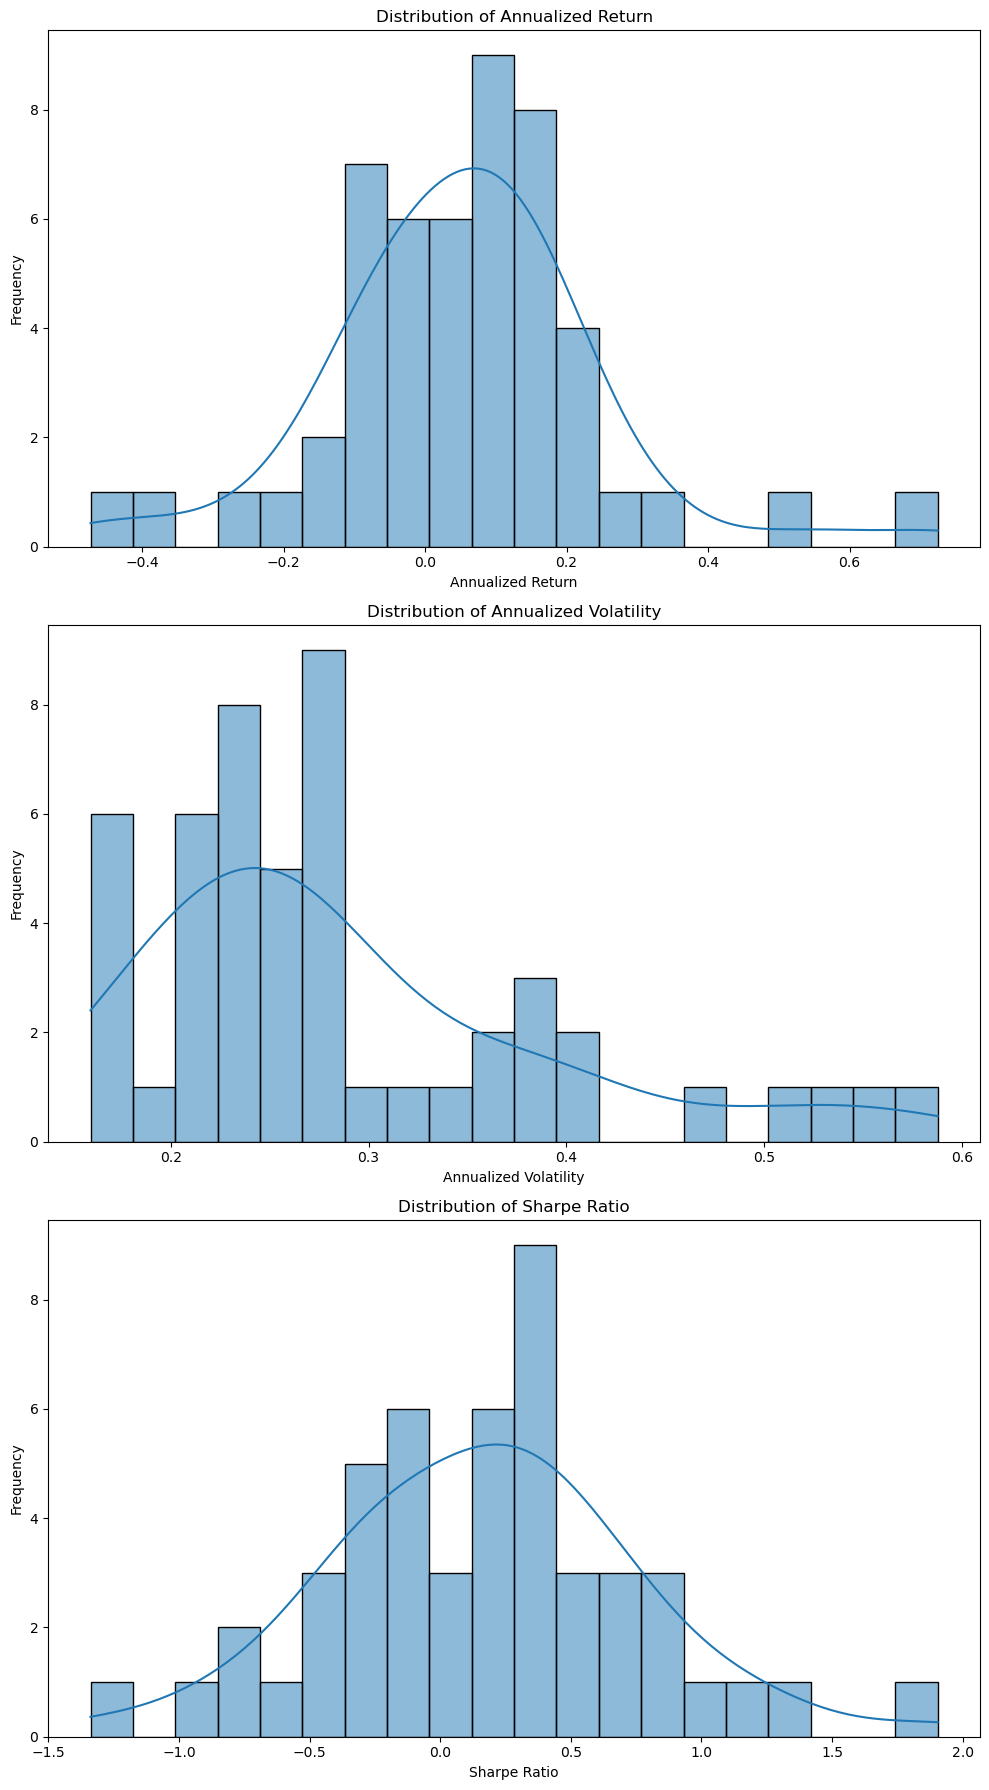

In [7]:
# Set up the figure and axes for the plots
fig, axes = plt.subplots(3, 1, figsize=(10, 18))

# Plot histograms for each metric
sns.histplot(metrics['Annualized Return'], bins=20, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Annualized Return')
axes[0].set_xlabel('Annualized Return')
axes[0].set_ylabel('Frequency')

sns.histplot(metrics['Annualized Volatility'], bins=20, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Annualized Volatility')
axes[1].set_xlabel('Annualized Volatility')
axes[1].set_ylabel('Frequency')

sns.histplot(metrics['Sharpe Ratio'], bins=20, kde=True, ax=axes[2])
axes[2].set_title('Distribution of Sharpe Ratio')
axes[2].set_xlabel('Sharpe Ratio')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

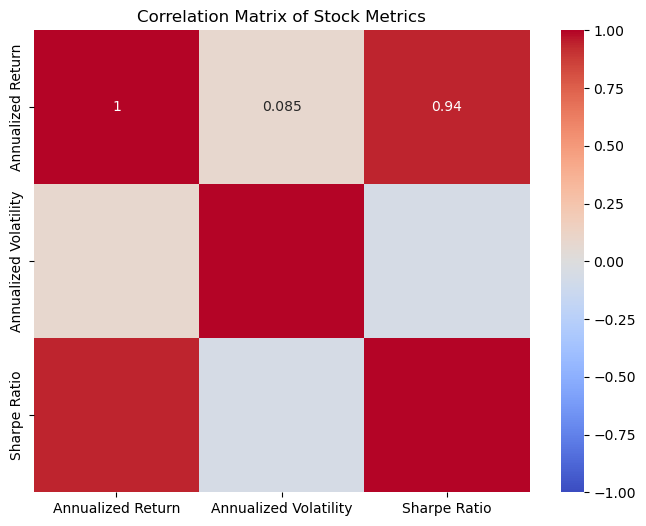

In [8]:
# Calculate and visualize the correlation matrix
correlation_matrix = metrics.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Stock Metrics')
plt.show()
#address 2nd row 3rd column 

In [9]:
# Calculating Q1 (25th percentile) and Q3 (75th percentile) for numerical columns
Q1 = data[['Open', 'Close', 'High', 'Low', 'Adjusted Close', 'Volume']].quantile(0.25)
Q3 = data[['Open', 'Close', 'High', 'Low', 'Adjusted Close', 'Volume']].quantile(0.75)

# Calculating IQR for each column
IQR = Q3 - Q1

# Defining bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Capping outliers by replacing them with the nearest valid value within the bounds
data_capped = data.copy()
data_capped[['Open', 'Close', 'High', 'Low', 'Adjusted Close', 'Volume']] = data_capped[['Open', 'Close', 'High', 'Low', 'Adjusted Close', 'Volume']].clip(lower=lower_bound, upper=upper_bound, axis=1)


Enter the company's abbreviated name (e.g., AAPL): AAPL
Enter the start date (YYYY-MM-DD): 2021-03-20
Enter the end date (YYYY-MM-DD): 2022-03-20


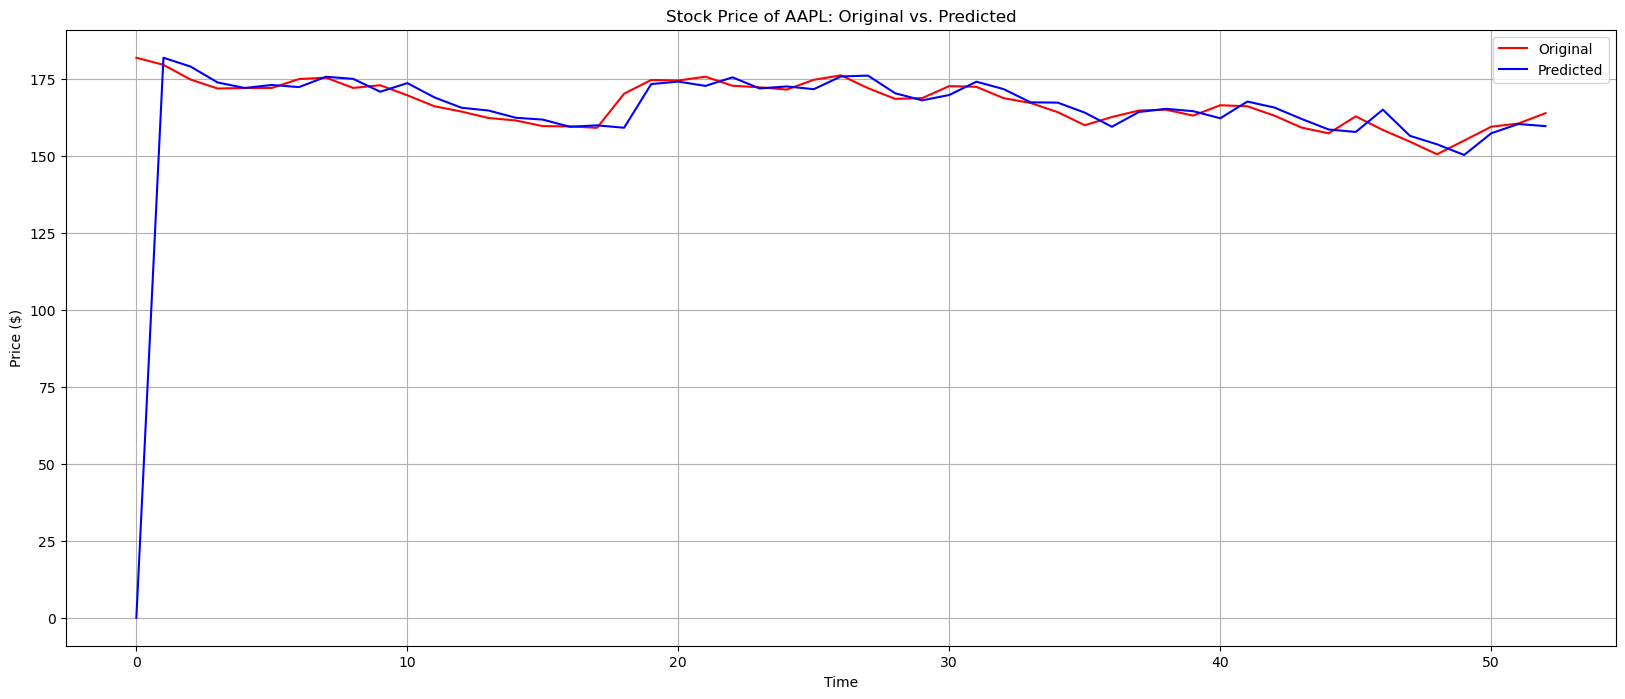

MAPE: 3.28%
AAPL forecast:
 53    164.191584
54    163.628433
55    163.190565
56    163.109063
57    163.257098
58    163.361646
59    163.371585
60    163.338553
61    163.315048
62    163.313786
Name: predicted_mean, dtype: float64


In [10]:
# Defining a dictionary to store filtered DataFrames
company_data = {}

# List of company names
company_names = data['Ticker'].unique()

# Filtering data for each company and store in the dictionary
for company in company_names:
    company_data[company] = data_capped[data_capped['Ticker'] == company]

# Taking user input for company, start date, and end date
company = input("Enter the company's abbreviated name (e.g., AAPL):")
start_date = input("Enter the start date (YYYY-MM-DD):")
end_date = input("Enter the end date (YYYY-MM-DD):")

stock_data = company_data[company]
stock_data = stock_data[(stock_data['Date'] >= start_date) & (stock_data['Date'] <= end_date)]

# Finding closing prices
closing_prices = stock_data['Close']

# Fitting the ARIMA model for company's stock
model = ARIMA(closing_prices, order=(5,1,0))
model_fit = model.fit()

# Making predictions for company's stock
predictions = model_fit.predict(typ='levels')

# Plot the original and predicted closing prices
plt.figure(figsize=(20,8))
plt.plot(closing_prices, color='red', label='Original')
plt.plot(predictions, color='blue', label='Predicted')
plt.title(f'Stock Price of {company}: Original vs. Predicted')
plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Checking error percentage
mape_company = mean_absolute_percentage_error(closing_prices, predictions)
print(f"MAPE: {mape_company:.2f}%")

# Forecasting future values
forecast = model_fit.get_forecast(steps=10).predicted_mean
print(f"{company} forecast:\n", forecast)


In [14]:
# Asking for user's risk level
risk_level = input("Enter your risk level (low, medium, high):").lower()

# Making a recommendation based on the user's risk level and stock's volatility
volatility_threshold = {'low': 0.2, 'medium': 0.5, 'high': 1.0}
stock_volatility = annualized_volatility[company]

if stock_volatility > volatility_threshold[risk_level]:
    recommendation = "not to buy" if risk_level != "high" else "to buy with caution"
else:
    recommendation = "to buy"

print(f"Based on your risk level and the stock's volatility, it is recommended {recommendation} the stock {company}.")


Enter your risk level (low, medium, high): low


Based on your risk level and the stock's volatility, it is recommended not to buy the stock AAPL.


In [15]:
closing_prices

0     182.009995
1     179.699997
2     174.919998
3     172.000000
4     172.169998
5     172.190002
6     175.080002
7     175.529999
8     172.190002
9     173.070007
10    169.800003
11    166.229996
12    164.509995
13    162.410004
14    161.619995
15    159.779999
16    159.690002
17    159.220001
18    170.330002
19    174.779999
20    174.610001
21    175.839996
22    172.899994
23    172.389999
24    171.660004
25    174.830002
26    176.279999
27    172.119995
28    168.639999
29    168.880005
30    172.789993
31    172.550003
32    168.880005
33    167.300003
34    164.320007
35    160.070007
36    162.740005
37    164.850006
38    165.119995
39    163.199997
40    166.559998
41    166.229996
42    163.169998
43    159.300003
44    157.440002
45    162.949997
46    158.520004
47    154.729996
48    150.619995
49    155.089996
50    159.589996
51    160.619995
52    163.979996
Name: Close, dtype: float64

In [17]:
data.head

<bound method NDFrame.head of       Ticker        Date        Open       Close        High         Low  \
0       AAPL  2022-01-03  177.830002  182.009995  182.880005  177.710007   
1       AAPL  2022-01-04  182.630005  179.699997  182.940002  179.119995   
2       AAPL  2022-01-05  179.610001  174.919998  180.169998  174.639999   
3       AAPL  2022-01-06  172.699997  172.000000  175.300003  171.639999   
4       AAPL  2022-01-07  172.889999  172.169998  174.139999  171.029999   
...      ...         ...         ...         ...         ...         ...   
31245    UPS  2024-06-24  137.800003  138.600006  139.639999  137.139999   
31246    UPS  2024-06-25  138.039993  134.360001  138.039993  134.050003   
31247    UPS  2024-06-26  136.479996  138.149994  138.949997  135.100006   
31248    UPS  2024-06-27  137.990005  135.830002  137.990005  135.190002   
31249    UPS  2024-06-28  136.179993  136.850006  137.199997  135.699997   

       Adjusted Close     Volume  Daily Return  
0       

In [18]:
company_data

{'AAPL':     Ticker        Date        Open       Close        High         Low  \
 0     AAPL  2022-01-03  177.830002  182.009995  182.880005  177.710007   
 1     AAPL  2022-01-04  182.630005  179.699997  182.940002  179.119995   
 2     AAPL  2022-01-05  179.610001  174.919998  180.169998  174.639999   
 3     AAPL  2022-01-06  172.699997  172.000000  175.300003  171.639999   
 4     AAPL  2022-01-07  172.889999  172.169998  174.139999  171.029999   
 ..     ...         ...         ...         ...         ...         ...   
 620   AAPL  2024-06-24  207.720001  208.139999  212.699997  206.589996   
 621   AAPL  2024-06-25  209.149994  209.070007  211.380005  208.610001   
 622   AAPL  2024-06-26  211.500000  213.250000  214.860001  210.639999   
 623   AAPL  2024-06-27  214.690002  214.100006  215.740005  212.350006   
 624   AAPL  2024-06-28  215.770004  210.619995  216.070007  210.300003   
 
      Adjusted Close    Volume  Daily Return  
 0        179.481110  42214950           Na